# ARI3210 - Speech Technology Assignment

In [1]:
# Importing libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import cv2
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from AlexNet import AlexNet
from tensorflow.keras.optimizers import SGD, Adam
from imutils import paths
import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Generating and Saving Mel-Spectrograms to Disk

In [2]:
new_corpus = 'corpus_img'
mel_spec_frame_size = 1024
n_mels = 90

In [3]:
def get_classes_in_data_path(datapath='./corpus'):
    """ Obtaining a list of classes/speakers in a directory """
    subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    class_labels = np.arange(0, len(subfolders))

    return subfolders, class_labels


def get_wav_files_in_path(datapath):
    """ Obtaining a list of wav files in a directory """
    files = os.listdir(datapath)
    files_wav = [i for i in files if i.endswith('.wav')]

    return files_wav


def get_all_images_from_path(path):
    """ Obtaining a list of png files in a directory """
    files = os.listdir(path)
    return [i for i in files if i.endswith('.png')]


def save_image(filepath, fig=None):
    """
    Save the current image with no whitespace to the given file path
    :param filepath: File path of PNG file to create
    :param fig: The matplotlib figure to save
    :return:
    """
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0, 0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
    fig.savefig(filepath, pad_inches=0, bbox_inches='tight')


def get_mel_spectrogram(wavfile, wav_file_path, n_mels=128, do_plot=False, do_save=False):
    """
    Given a path to a wav file, returns a Mel-spectrogram array,
    np.ndarray [shape=(n_mels,t)]
    :param do_save: Flag to either save the spectrogram or not
    :param wavfile: The input wav file path
    :param n_mels: The number of mel spectrogram filters
    :param do_plot: Flag to either plot the spectrogram or not (for debugging)
    :return: Returns a tuple of np.ndarray [shape=(n_mels,t)] and fs
    """

    sig, fs = librosa.load(wavfile, sr=None)

    # Normalise the time-domain signal, i.e. 'sig' to -1.0 - 1.0
    sig_norm = librosa.util.normalize(sig)

    mel_spec = librosa.feature.melspectrogram(y=sig_norm,
                                              sr=fs,
                                              center=True,
                                              n_fft=mel_spec_frame_size,
                                              hop_length=int(mel_spec_frame_size / 2),
                                              n_mels=n_mels)

    mel_spec = librosa.power_to_db(mel_spec, ref=1.0)

    if do_plot:
        plot_mel_spectrum(mel_spec, fs, mel_spec_frame_size, wav_file_path, do_save)

    return mel_spec, fs


def plot_mel_spectrum(mel_spec, fs, mel_spec_frame_size, wav_file_path, save=False):
    """ Plots a Mel Spectrum """
    plt.figure(figsize=(20, 8))
    plt.xlabel('Time')
    plt.ylabel('Mel-Frequency')
    librosa.display.specshow(mel_spec,
                             y_axis='mel',
                             fmax=fs / 2,
                             sr=fs,
                             hop_length=int(mel_spec_frame_size / 2),
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

    if save:
        save_image(new_corpus + '/' + '/'.join(wav_file_path.split('/')[2:])[:-4])

    # plt.show()


def dataset_generation():
    """ Function that generates new corpus containing all chunked Mel-Spectrograms """
    sub_folders, _ = get_classes_in_data_path()
    wav_files_list = [get_wav_files_in_path(file_wav_path) for file_wav_path in sub_folders]

    os.makedirs(new_corpus, exist_ok=True)
    # Iterating over every speaker and their respective wav file
    # This nested for loop will create a directory for each speaker containing their respective mel-spectrograms
    for i, folder in enumerate(sub_folders):
        
        os.makedirs(new_corpus + '/' + folder[-6:], exist_ok=True)
        for wav_file in wav_files_list[i]:
            wav_file_path = folder + '/' + wav_file

            mel_spec, fs = get_mel_spectrogram(wav_file_path, wav_file_path, n_mels)
            m = mel_spec.shape[0]

            for j in range(0, mel_spec.shape[1], m):
                sub_wav_file = wav_file[:-4] + str(int(j/90)) + wav_file[-4:]
                sub_wav_file_path = folder + '/' + sub_wav_file

                plot_mel_spectrum(mel_spec[:, j:j+m], fs, mel_spec_frame_size, sub_wav_file_path, True)

In [56]:
dataset_generation()  # generates and saves chunked mel-spectrograms to disk of respective speaker

### Creating a List of All Chunked Images Paths

In [4]:
subfolders, class_labels = get_classes_in_data_path('corpus_img')

paths_to_images = []
for folder in subfolders:
    imgs = get_all_images_from_path(folder)  # gets all PNG images in this folder path
    for img in imgs:
        paths_to_images.append(folder+'/'+img)

print(paths_to_images)        

['corpus_img/apd001/shortpassagec_CT27.png', 'corpus_img/apd001/shortpassagec_CT26.png', 'corpus_img/apd001/shortpassagec_CT24.png', 'corpus_img/apd001/shortpassagec_CT18.png', 'corpus_img/apd001/shortpassagec_CT8.png', 'corpus_img/apd001/shortpassagec_CT9.png', 'corpus_img/apd001/shortpassagec_CT19.png', 'corpus_img/apd001/shortpassagec_CT25.png', 'corpus_img/apd001/shortpassagec_CT21.png', 'corpus_img/apd001/shortpassageb_CT8.png', 'corpus_img/apd001/shortpassageb_CT9.png', 'corpus_img/apd001/shortpassagec_CT20.png', 'corpus_img/apd001/shortpassagec_CT22.png', 'corpus_img/apd001/shortpassagec_CT23.png', 'corpus_img/apd001/shortpassagea_CT17.png', 'corpus_img/apd001/shortpassagea_CT16.png', 'corpus_img/apd001/shortpassagea_CT14.png', 'corpus_img/apd001/shortpassagea_CT15.png', 'corpus_img/apd001/shortpassagea_CT11.png', 'corpus_img/apd001/shortpassagea_CT10.png', 'corpus_img/apd001/shortpassagea_CT12.png', 'corpus_img/apd001/shortpassagea_CT8.png', 'corpus_img/apd001/shortpassagea_CT9

### Simple Processor

In [5]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),
                          interpolation=self.inter)

### Image To Array Preprocessor

In [6]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image

        """ Add data normalisation to array """

        return img_to_array(image, data_format=self.dataFormat)


### Data Loader

In [7]:
class DataLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an
        # empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg

            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            # if self.preprocessors is not None:
            # loop over the preprocessors and apply each to the image
            for p in self.preprocessors:
                image = p.preprocess(image)

            # treat our processed image as a "feature vector"
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every ‘verbose‘ images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))


### CNN Design, Training and Evaluation

#### ShallowNet 

In [8]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last"
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # define the first (and only) CONV => RELU layer
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        model.summary()
        return model


[INFO] processed 20/1151
[INFO] processed 40/1151
[INFO] processed 60/1151
[INFO] processed 80/1151
[INFO] processed 100/1151
[INFO] processed 120/1151
[INFO] processed 140/1151
[INFO] processed 160/1151
[INFO] processed 180/1151
[INFO] processed 200/1151
[INFO] processed 220/1151
[INFO] processed 240/1151
[INFO] processed 260/1151
[INFO] processed 280/1151
[INFO] processed 300/1151
[INFO] processed 320/1151
[INFO] processed 340/1151
[INFO] processed 360/1151
[INFO] processed 380/1151
[INFO] processed 400/1151
[INFO] processed 420/1151
[INFO] processed 440/1151
[INFO] processed 460/1151
[INFO] processed 480/1151
[INFO] processed 500/1151
[INFO] processed 520/1151
[INFO] processed 540/1151
[INFO] processed 560/1151
[INFO] processed 580/1151
[INFO] processed 600/1151
[INFO] processed 620/1151
[INFO] processed 640/1151
[INFO] processed 660/1151
[INFO] processed 680/1151
[INFO] processed 700/1151
[INFO] processed 720/1151
[INFO] processed 740/1151
[INFO] processed 760/1151
[INFO] processed

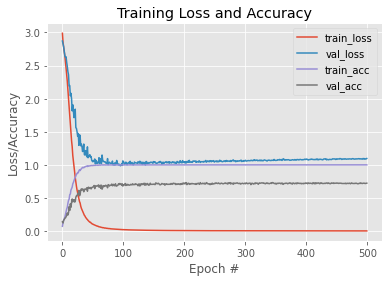

In [62]:
n_epochs = 500

# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor(dataFormat="channels_last")

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = DataLoader(preprocessors=[sp, iap])
(data, txt_labels) = sdl.load(paths_to_images, verbose=20)
data = data.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
labels = lb.fit_transform(txt_labels)
# one hot encode labels
# labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, random_state=42)

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=8, epochs=n_epochs, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=8)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#### Novel Network

In [9]:
class NovelNetwork:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last"
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))

        # 1st Fully Connected Layer
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Dropout(0.2))

        # 2nd Fully Connected Layer
        model.add(Dense(classes))
        model.add(Dropout(0.2))

        # 3rd Fully Connected Layer
        model.add(Dense(classes))
    
        # softmax classifier
        model.add(Activation("softmax"))

        # return the constructed network architecture
        model.summary()
        return model


[INFO] processed 20/1151
[INFO] processed 40/1151
[INFO] processed 60/1151
[INFO] processed 80/1151
[INFO] processed 100/1151
[INFO] processed 120/1151
[INFO] processed 140/1151
[INFO] processed 160/1151
[INFO] processed 180/1151
[INFO] processed 200/1151
[INFO] processed 220/1151
[INFO] processed 240/1151
[INFO] processed 260/1151
[INFO] processed 280/1151
[INFO] processed 300/1151
[INFO] processed 320/1151
[INFO] processed 340/1151
[INFO] processed 360/1151
[INFO] processed 380/1151
[INFO] processed 400/1151
[INFO] processed 420/1151
[INFO] processed 440/1151
[INFO] processed 460/1151
[INFO] processed 480/1151
[INFO] processed 500/1151
[INFO] processed 520/1151
[INFO] processed 540/1151
[INFO] processed 560/1151
[INFO] processed 580/1151
[INFO] processed 600/1151
[INFO] processed 620/1151
[INFO] processed 640/1151
[INFO] processed 660/1151
[INFO] processed 680/1151
[INFO] processed 700/1151
[INFO] processed 720/1151
[INFO] processed 740/1151
[INFO] processed 760/1151
[INFO] processed

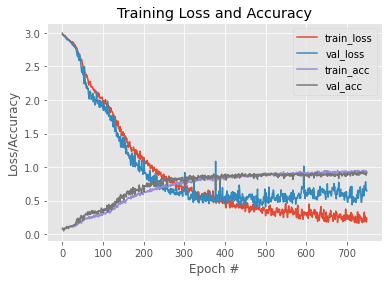

In [69]:
n_epochs = 750

# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor(dataFormat="channels_last")

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = DataLoader(preprocessors=[sp, iap])
(data, txt_labels) = sdl.load(paths_to_images, verbose=20)
data = data.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
labels = lb.fit_transform(txt_labels)
# one hot encode labels
# labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, random_state=42)

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.01)
novelnet_model = NovelNetwork.build(width=32, height=32, depth=3, classes=len(lb.classes_))
novelnet_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = novelnet_model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=8, epochs=n_epochs, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = novelnet_model.predict(testX, batch_size=8)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


### K-Fold Cross Validation 

In [11]:
def initialise_model(name, alpha):
    """ Function that initialises either ShallowNet or Novel Network model """
    if name == "ShallowNet":
        opt = SGD(learning_rate=alpha)
        shallownet = ShallowNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
        shallownet.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return shallownet

    else:
        opt = SGD(learning_rate=alpha)
        novelnet = NovelNetwork.build(width=32, height=32, depth=3, classes=len(lb.classes_))
        novelnet.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return novelnet    


def k_fold_cross_validation(k, alpha, n_epochs, model_name):
    """ Function that performs k-Fold Cross Validation """
    accuracy_score_list = []
    precision_score_list = []
    recall_score_list = []
    f1_score_list = []
    
    for _ in range(k):

        model = initialise_model(model_name, alpha)

        trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, shuffle=True, random_state=None)
        
        H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=8, epochs=n_epochs, verbose=1)

        # evaluate the network
        print("[INFO] evaluating network...")
        predictions = model.predict(testX, batch_size=8)
                            
        accuracy = accuracy_score(predictions.argmax(axis=1), testY.argmax(axis=1))
        precision = precision_score(testY.argmax(axis=1), predictions.argmax(axis=1), average='macro')
        recall = recall_score(testY.argmax(axis=1), predictions.argmax(axis=1), average='macro')
        f1 =  f1_score(testY.argmax(axis=1), predictions.argmax(axis=1), average='macro')

        accuracy_score_list.append(accuracy)
        precision_score_list.append(precision)
        recall_score_list.append(recall)
        f1_score_list.append(f1)

    return accuracy_score_list, precision_score_list, recall_score_list, f1_score_list

In [12]:
k = 5  # k value

In [13]:
accuracy_shallownet, precision_shallownet, recall_shallownet, f1_shallownet = k_fold_cross_validation(k, 0.005, 500, "ShallowNet")
avg_accuracy_shallownet = sum(accuracy_shallownet)/k
avg_precision_shallownet = sum(precision_shallownet)/k
avg_recall_shallownet = sum(recall_shallownet)/k
avg_f1_shallownet = sum(f1_shallownet)/k

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 20)                655380    
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
Total params: 656,276
Trainable params: 656,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
115/115 [=============================

In [15]:
# Performing k-Fold Cross Validation on Novel Network
accuracy_novelnet, precision_novelnet, recall_novelnet, f1_novelnet = k_fold_cross_validation(k, 0.01, 750, "Novel Network")

# Collating average global results
avg_accuracy_novelnet = sum(accuracy_novelnet)/k
avg_precision_novelnet = sum(precision_novelnet)/k
avg_recall_novelnet = sum(recall_novelnet)/k
avg_f1_novelnet = sum(f1_novelnet)/k

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 16, 16, 32)        0         
                                                      

/opt/anaconda3/envs/speech/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_22 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 activation_23 (Activation)  (None, 16, 16, 32)        0         
                                                      

/opt/anaconda3/envs/speech/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print('Global Results for ShallowNet after 5-Fold Cross Validation')
print('------------------------------------------------------------------')
print(f'Precision: {round(avg_precision_shallownet, 2)}%')
print(f'Recall: {round(avg_recall_shallownet, 2)}%')
print(f'F1-Score: {round(avg_f1_shallownet, 2)}%')
print(f'Accuracy: {round(avg_accuracy_shallownet, 2)}%')

print()

print('Global Results for Novel Network after 5-Fold Cross Validation')
print('------------------------------------------------------------------')
print(f'Precision: {round(avg_precision_novelnet, 2)}%')
print(f'Recall: {round(avg_recall_novelnet, 2)}%')
print(f'F1-Score: {round(avg_f1_novelnet, 2)}%')
print(f'Accuracy: {round(avg_accuracy_novelnet, 2)}%')

Global Results for ShallowNet after 5-Fold Cross Validation
------------------------------------------------------------------
Precision: 0.64%
Recall: 0.63%
F1-Score: 0.62%
Accuracy: 0.66%

Global Results for Novel Network after 5-Fold Cross Validation
------------------------------------------------------------------
Precision: 0.84%
Recall: 0.84%
F1-Score: 0.82%
Accuracy: 0.87%


### Box Plots

In [31]:
def generate_box_plot(accuracy_list, precision_list, recall_list, f1_list, model_name):
    """ Function that generates a Box Plot """
    fig = plt.figure(figsize =(10, 7))

    # Creating plot
    plt.boxplot([accuracy_list, precision_list, recall_list, f1_list])
    
    # show plot
    plt.title(f"Box Plot for {model_name}")
    plt.xticks([1, 2, 3, 4], ['Accuracy', 'Precision', 'Recall', 'F1'])
    plt.show()

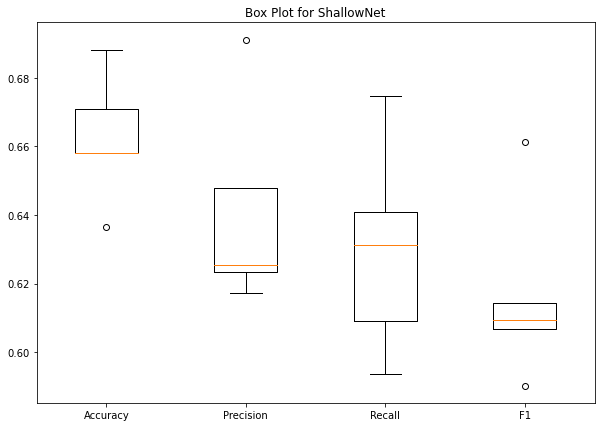

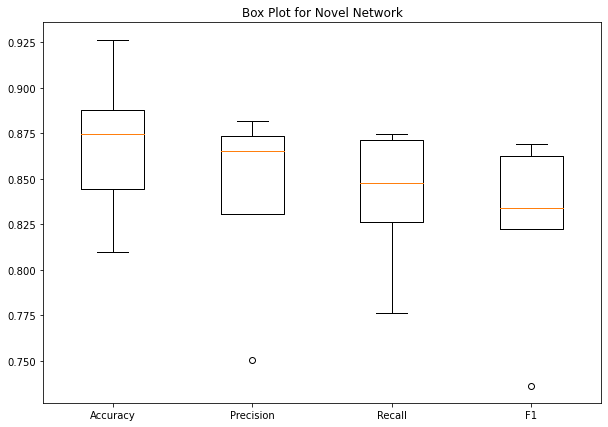

In [32]:
generate_box_plot(accuracy_shallownet, precision_shallownet, recall_shallownet, f1_shallownet, "ShallowNet")
generate_box_plot(accuracy_novelnet, precision_novelnet, recall_novelnet, f1_novelnet, "Novel Network")